## Colin's active development sandbox

In [1]:
from enum import Enum
from pathlib import Path
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
import torchvision.transforms as transforms
import numpy as np
from tqdm.auto import tqdm
import os
import re
import cv2
from PIL import Image
import math
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt
import logging

from DataPreProcessing import DataPreProcessing, DataPaths
from DataAugmentation import DataAugmentation, LegalTransformations, ImageEnhancement

### Tracklet iterator

[2025-02-26 21:50:10] - [INFO]: DataPreProcessing initialized.
[2025-02-26 21:50:10] - [INFO]: ROOT_DATA_DIR: c:\Users\colin\OneDrive\Desktop\UBC\Jersey-Number-Recognition\data\SoccerNet\jersey-2023\extracted
[2025-02-26 21:50:10] - [INFO]: TRAIN_DATA_DIR: c:\Users\colin\OneDrive\Desktop\UBC\Jersey-Number-Recognition\data\SoccerNet\jersey-2023\extracted\train\images
[2025-02-26 21:50:10] - [INFO]: TEST_DATA_DIR: c:\Users\colin\OneDrive\Desktop\UBC\Jersey-Number-Recognition\data\SoccerNet\jersey-2023\extracted\test\images
[2025-02-26 21:50:10] - [INFO]: VAL_DATA_DIR: c:\Users\colin\OneDrive\Desktop\UBC\Jersey-Number-Recognition\data\SoccerNet\jersey-2023\extracted\challenge\images
[2025-02-26 21:50:10] - [INFO]: Using device: cuda
[2025-02-26 21:50:10] - [INFO]: ['0', '1', '10', '100', '1000', '1001', '1002', '1003', '1004', '1005']
[2025-02-26 21:50:10] - [INFO]: Min tracklet: 0
[2025-02-26 21:50:10] - [INFO]: Max tracklet: 1426


Processing tracks:   0%|          | 0/1 [00:00<?, ?it/s]

dict_items([('rotation', <LegalTransformations.rotation: 40>), ('blur', <LegalTransformations.blur: 3>), ('brightness', <LegalTransformations.brightness: (0.7, 1.0)>), ('contrast', <LegalTransformations.brightness: (0.7, 1.0)>), ('stretch', <LegalTransformations.stretch: (0.7, 1.3)>), ('horizontal_flip', <LegalTransformations.horizontal_flip: True>)])


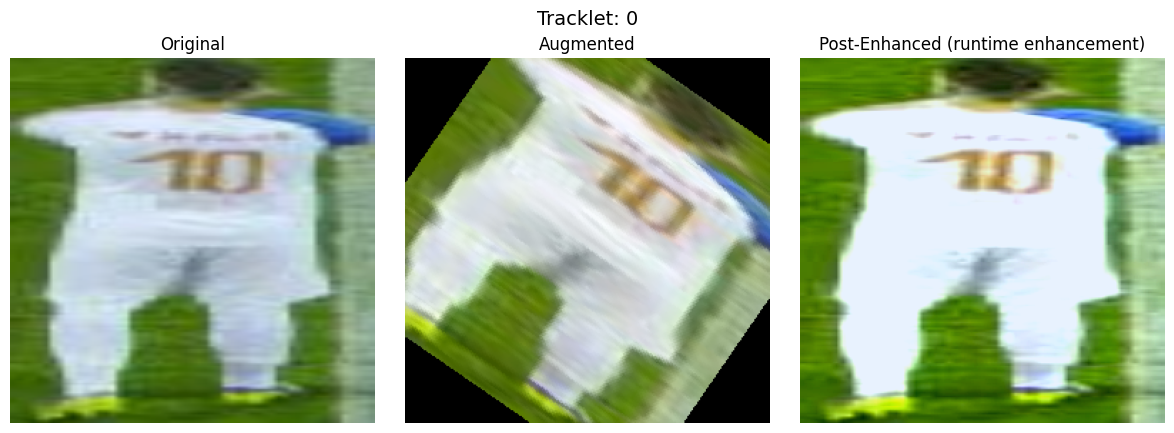

In [6]:
input_folder = DataPaths.TRAIN_DATA_DIR.value

NUM_TRACKLETS = 1
NUM_IMGS_PER_TRACKLET = 1

# Instantiate the pre-processing class and load data
data_pre = DataPreProcessing()
data_dict = data_pre.generate_features(input_folder, DataPaths.TEMP_EXPERIMENT_DIR.value, num_tracks=NUM_TRACKLETS)

# Instantiate the augmentor and augment the data using specific transformations
augmentor = DataAugmentation(data_dict)
print(LegalTransformations.__members__.items())
enhance = ImageEnhancement()
augmented_data = augmentor.augment_data(["contrast", "brightness", "rotation", "blur", "stretch", "horizontal_flip"])
selected_tracks = list(data_dict.keys())[:NUM_TRACKLETS]

# For each tracklet, display each image with its augmented and post-enhanced versions side by side.
for track in selected_tracks:
    # Get original images (up to NUM_IMGS_PER_TRACKLET) for the tracklet.
    orig_tensor = data_dict[track][:NUM_IMGS_PER_TRACKLET]  # shape: (N, C, H, W)
    
    # Enhance each image individually (enhance_image expects a 3D tensor)
    post_enhance_list = []
    for i in range(orig_tensor.shape[0]):
        enhanced = enhance.enhance_image(orig_tensor[i])
        post_enhance_list.append(enhanced)
    post_enhance_tensor = torch.stack(post_enhance_list)  # shape: (N, C, H, W)
    
    # Get the corresponding augmented results (each is a dict mapping augmentation type to tensor)
    aug_list = augmented_data[track][:NUM_IMGS_PER_TRACKLET]
    num_images = orig_tensor.shape[0]
    
    # Create a figure with num_images rows and 3 columns (Original, Augmented, Post-Enhanced)
    fig, axs = plt.subplots(num_images, 3, figsize=(12, num_images * 4))
    if num_images == 1:
        axs = [axs]  # Ensure we can iterate over rows
    
    for i in range(num_images):
        # Process original image
        orig_img = orig_tensor[i].permute(1, 2, 0).numpy()
        orig_img = (orig_img - orig_img.min()) / (orig_img.max() - orig_img.min() + 1e-6)
        axs[i][0].imshow(orig_img)
        axs[i][0].set_title("Original")
        axs[i][0].axis("off")
        
        # Choose an augmented version from the augmentation dictionary.
        aug_dict = aug_list[i]
        if "rotation" in aug_dict:
            aug_img_tensor = aug_dict["rotation"]
        elif "blur" in aug_dict:
            aug_img_tensor = aug_dict["blur"]
        elif "brightness" in aug_dict:
            aug_img_tensor = aug_dict["brightness"]
        elif "contrast" in aug_dict:
            aug_img_tensor = aug_dict["contrast"]
        elif "stretch" in aug_dict:
            aug_img_tensor = aug_dict["stretch"]
        elif "horizontal_flip" in aug_dict:
            aug_img_tensor = aug_dict["horizontal_flip"]
        else:
            aug_img_tensor = aug_dict["original"]
            
        # Process post-enhanced image
        post_img_tensor = post_enhance_tensor[i]
        post_img = post_img_tensor.permute(1, 2, 0).numpy()
        post_img = (post_img - post_img.min()) / (post_img.max() - post_img.min() + 1e-6)
        axs[i][2].imshow(post_img)
        axs[i][2].set_title("Post-Enhanced (runtime enhancement)")
        axs[i][2].axis("off")
        
        aug_img = aug_img_tensor.permute(1, 2, 0).numpy()
        aug_img = (aug_img - aug_img.min()) / (aug_img.max() - aug_img.min() + 1e-6)
        axs[i][1].imshow(aug_img)
        axs[i][1].set_title("Augmented")
        axs[i][1].axis("off")
    
    plt.tight_layout()
    plt.suptitle(f"Tracklet: {track}", fontsize=14, y=1.07)
    plt.show()